Shape:  (3024, 4032)


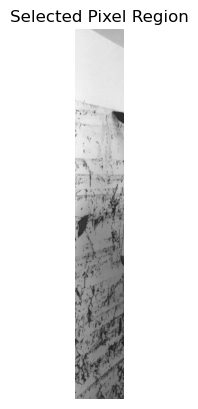

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal
import xarray as xr

# Load image in grayscale
impath = 'C:/crs/proj/2025_NOPP_comparison/michael_wl/IMG_1267.JPG'
image = cv2.imread(impath, cv2.IMREAD_GRAYSCALE)
print('Shape: ', image.shape )
# Select a region of interest (ROI)
roi = image[:, 1200:1600]  # Extracts a 20x20 pixel region
#print(roi)

# Show the extracted region
plt.imshow(roi, cmap='gray')  # Use cmap='gray' for grayscale images
plt.title("Selected Pixel Region")
plt.axis("off")
plt.show()

In [2]:
# Read saved coordinates from CSV
df = pd.read_csv("C:/crs/proj/2025_NOPP_comparison/michael_wl/clicked_coordinates.csv")
clicked_points = df.values  # Convert back to NumPy array

# Draw red dots at saved locations
for (x, y) in clicked_points:
    cv2.circle(image, (x, y), 7, (255, 0, 0), -1)

# Display the image with saved points
cv2.imshow("Replotted Image", image)
# External window will close on any keypress
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:

# Read in the water-level time series
tspath = 'C:/crs/proj/2025_NOPP_comparison/michael_wl/FLBAY03283_stormtide_unfiltered.nc'
ds = xr.open_dataset( tspath )
ds

<xarray.Dataset> Size: 147kB
Dimensions:                                                (time: 3669,
                                                            station_id: 10)
Coordinates:
  * time                                                   (time) datetime64[ns] 29kB ...
    altitude                                               float64 8B ...
    latitude                                               float64 8B ...
    longitude                                              float64 8B ...
  * station_id                                             (station_id) object 80B ...
Data variables:
    air_pressure                                           (time) float64 29kB ...
    water_surface_height_above_reference_datum             (time) float64 29kB ...
    unfiltered_water_surface_height_above_reference_datum  (time) float64 29kB ...
    wave_wl                                                (time) float64 29kB ...
Attributes: (12/55)
    cdm_data_type:                                station
    comment:                                      not used at this time
    Conventions:                                  CF-1.6
    date_created:                                 2018-10-15T18:50:15Z
    date_modified:                                2018-10-15T18:50:15Z
    geospatial_lat_units:                         degrees_north
    ...                                           ...
    sea_pressure_instrument_make:                 Hobo
    sea_pressure_instrument_model:                U20
    sea_pressure_instrument_serial_number:        202041
    title:                                        Calculation of water level ...
    summary:                                      This file contains three ti...
    uuid:                                         20a8b000-4994-4281-ada5-478...

In [4]:
# Convert to seconds since Unix epoch (1970-01-01T00:00:00)
seconds_since_epoch = ds.time.astype('float').values // 10**9  # Convert nanoseconds to seconds
# Convert to relative seconds since start of record
ts = seconds_since_epoch - seconds_since_epoch[0]
print(ts)

[0.0000e+00 3.0000e+01 6.0000e+01 ... 1.0998e+05 1.1001e+05 1.1004e+05]


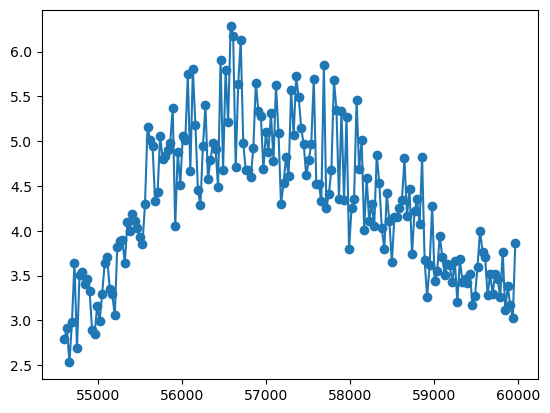

In [5]:
# subsample around peak of water level
ids, ide = 1820, 2000
t = ts[ids:ide]
z = ds.unfiltered_water_surface_height_above_reference_datum[ids:ide].values
plt.plot(t,z,'-o')

Local unsmoothed maxima coordinates:
[[5.47200000e+04 3.63989128e+00]
 [5.48700000e+04 3.46225992e+00]
 [5.49900000e+04 3.15755129e+00]
 [5.51100000e+04 3.70257905e+00]
 [5.52900000e+04 3.89432725e+00]
 [5.54100000e+04 4.18321471e+00]
 [5.55900000e+04 5.16290777e+00]
 [5.57400000e+04 5.05659014e+00]
 [5.58900000e+04 5.36698861e+00]
 [5.60100000e+04 5.05316881e+00]
 [5.61300000e+04 5.80645187e+00]
 [5.62800000e+04 5.40254839e+00]
 [5.64600000e+04 5.90633700e+00]
 [5.65800000e+04 6.27975967e+00]
 [5.67000000e+04 6.12973540e+00]
 [5.68800000e+04 5.65225795e+00]
 [5.70000000e+04 5.09819101e+00]
 [5.71200000e+04 5.62622953e+00]
 [5.72400000e+04 4.82506494e+00]
 [5.73600000e+04 5.72200305e+00]
 [5.75700000e+04 5.69364502e+00]
 [5.76900000e+04 5.85024926e+00]
 [5.78100000e+04 5.68070106e+00]
 [5.79600000e+04 5.26453518e+00]
 [5.80800000e+04 5.46087234e+00]
 [5.82000000e+04 4.58627036e+00]
 [5.83200000e+04 4.84782431e+00]
 [5.84400000e+04 4.41727194e+00]
 [5.86500000e+04 4.80679459e+00]
 [5.88

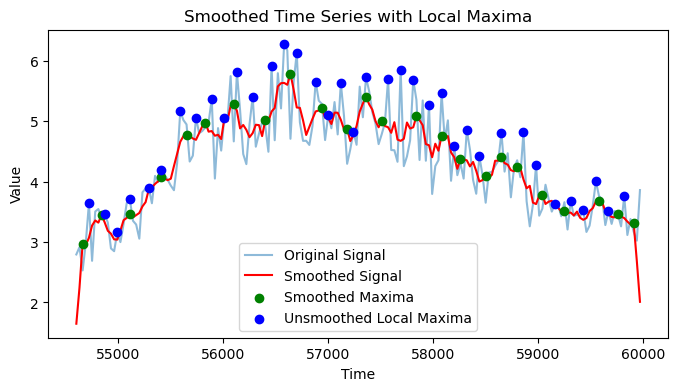

In [6]:
# Smooth using a moving average filter
# delta-t is 30 sec, so window is 150 s
window_size = 5
z_smooth = np.convolve(z, np.ones(window_size)/window_size, mode='same')

# Find peaks (local maxima) from smoothed data
peaks, _ = signal.find_peaks(z_smooth, distance=5)  # Adjust distance as needed
# ...from unsmoothed data over shorter distance
peakus, _ = signal.find_peaks(z, distance=4)  # Adjust distance as needed


# Extract coordinates of maxima
peaks_coords = np.column_stack((t[peaks], z_smooth[peaks]))
peakus_coords = np.column_stack((t[peakus], z[peakus]))

print("Local unsmoothed maxima coordinates:")
print(peakus_coords)


print("Local unsmoothed maxima coordinates:")
print(peaks_coords)


plt.figure(figsize=(8, 4))
plt.plot(t, z, label="Original Signal", alpha=0.5, zorder=0)  # Raw data
plt.plot(t, z_smooth, label="Smoothed Signal", color="red", zorder=1)  # Smoothed curve
plt.scatter(t[peaks], z_smooth[peaks], color="green", marker="o", zorder=2, label="Smoothed Maxima")  # Peaks
plt.scatter(t[peakus], z[peakus], color="blue", marker="o", zorder=3, label="Unsmoothed Local Maxima")  # Peaks

plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Smoothed Time Series with Local Maxima")
plt.show()

In [7]:
print('Max. wl: ',np.max(z),'(m)')
print('HWM    : ', 0.3048*17.9, '(m)')

Max. wl:  6.2797596691105815 (m)
HWM    :  5.45592 (m)


In [8]:
# convert clicked points into elevation
hwm_range = 1. # (m) this represents the distance from the top seed line to the bottom seed line
hwm_scale = hwm_range/(637-2756) # m/pix
hwm_offset = 637. # top seed line (pix)
hwm_max = 6.28 # top seed line (m)
hwm_max = .3048*17.9 # top seed line (m)
hwm_pix = clicked_points[:,1]
hwm = (hwm_pix-hwm_offset)*hwm_scale + hwm_max
print(hwm)

[5.45592    5.4285486  5.38418805 5.25440985 5.19636361 5.17748678
 5.1416208  5.12085629 5.04770858 5.03402288 4.94671755 4.91415502
 4.8886713  4.86460334 4.79287139 4.7588931  4.73293746 4.717836
 4.68008234 4.63241835 4.59136125 4.57059673 4.51774161 4.45592   ]


In [9]:
# Rising peaks, unsmoothed
pup = z[peakus][0:14]
print(pup)
# Falling peaks, unsmoothed
pdn = z[peakus][13:]
print(pdn)

# Rising peaks, smoothed
pups = z[peaks][0:10]
print(pups)
# Falling peaks, smoothed
pdns = z[peaks][9:]
print(pdns)

[3.63989128 3.46225992 3.15755129 3.70257905 3.89432725 4.18321471
 5.16290777 5.05659014 5.36698861 5.05316881 5.80645187 5.40254839
 5.906337   6.27975967]
[6.27975967 6.1297354  5.65225795 5.09819101 5.62622953 4.82506494
 5.72200305 5.69364502 5.85024926 5.68070106 5.26453518 5.46087234
 4.58627036 4.84782431 4.41727194 4.80679459 4.81864902 4.27417278
 3.62543276 3.68133504 3.52130903 4.00214759 3.51343444 3.76416504]
[2.52928685 3.40094748 3.70257905 4.18321471 4.94417208 4.89759127
 4.66399304 4.91643844 4.70715906 5.28329073]
[5.28329073 4.29346503 5.72200305 4.78506193 5.35215137 5.46087234
 4.30033123 3.64926291 4.80679459 4.35110131 3.55082903 3.65756292
 3.75861264 3.45931678 3.16920015]


In [10]:
# Run through the rising peaks and make sure each is higher than the last
ip_rising = []
lastp = 0.
for i, p in enumerate(peakus_coords):
    if(p[1] > lastp):
        ip_rising.append(i)
        lastp = p[1]
        print(i,p)

# Run through the falling peaks and make sure each is lower than the last
ip_falling = []
lastp = 0.
for i, p in enumerate(np.flipud(peakus_coords)):
    if(p[1] > lastp):
        ip_falling.append(i)
        lastp = p[1]
        print(i,p)

ppdn = np.flipud( peakus_coords )[ip_falling]
ppup = peakus_coords[ip_rising]
print('ppup:',ppup)
print('ppdn:',ppdn)

0 [5.47200000e+04 3.63989128e+00]
3 [5.51100000e+04 3.70257905e+00]
4 [5.52900000e+04 3.89432725e+00]
5 [5.54100000e+04 4.18321471e+00]
6 [5.55900000e+04 5.16290777e+00]
8 [5.58900000e+04 5.36698861e+00]
10 [5.61300000e+04 5.80645187e+00]
12 [5.646000e+04 5.906337e+00]
13 [5.65800000e+04 6.27975967e+00]
0 [5.98200000e+04 3.76416504e+00]
2 [5.95500000e+04 4.00214759e+00]
6 [5.89800000e+04 4.27417278e+00]
7 [5.88600000e+04 4.81864902e+00]
10 [5.83200000e+04 4.84782431e+00]
12 [5.80800000e+04 5.46087234e+00]
14 [5.78100000e+04 5.68070106e+00]
15 [5.76900000e+04 5.85024926e+00]
22 [5.6700000e+04 6.1297354e+00]
23 [5.65800000e+04 6.27975967e+00]
ppup: [[5.47200000e+04 3.63989128e+00]
 [5.51100000e+04 3.70257905e+00]
 [5.52900000e+04 3.89432725e+00]
 [5.54100000e+04 4.18321471e+00]
 [5.55900000e+04 5.16290777e+00]
 [5.58900000e+04 5.36698861e+00]
 [5.61300000e+04 5.80645187e+00]
 [5.64600000e+04 5.90633700e+00]
 [5.65800000e+04 6.27975967e+00]]
ppdn: [[5.98200000e+04 3.76416504e+00]
 [5.9550

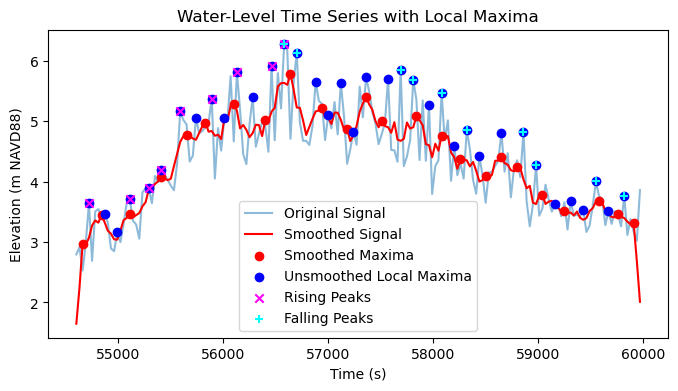

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(t, z, label="Original Signal", alpha=0.5, zorder=0)  # Raw data
plt.plot(t, z_smooth, label="Smoothed Signal", color="red", zorder=1)  # Smoothed curve
plt.scatter(t[peaks], z_smooth[peaks], color="red", marker="o", zorder=2, label="Smoothed Maxima")  # Peaks
plt.scatter(t[peakus], z[peakus], color="blue", marker="o", zorder=3, label="Unsmoothed Local Maxima")  # Peaks
plt.scatter(ppup[:,0], ppup[:,1], color='magenta', marker='x', zorder=4, label='Rising Peaks')
plt.scatter(ppdn[:,0], ppdn[:,1], color='cyan', marker='+', zorder=4, label='Falling Peaks')

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Elevation (m NAVD88)")
plt.title("Water-Level Time Series with Local Maxima")
plt.show()

Text(0, 0.5, 'Elevation (m NAVD88)')

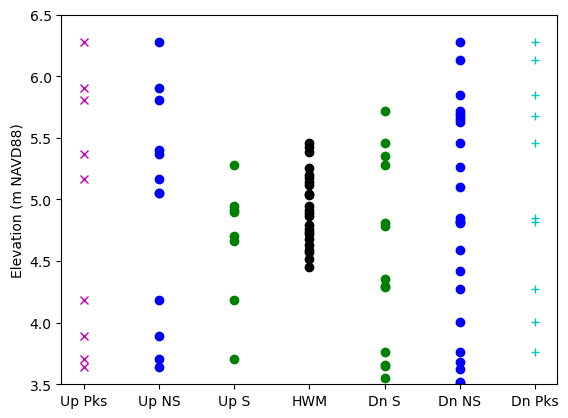

In [12]:
plt.plot( -3*np.ones_like(ppup), ppup,'xm' )
plt.plot( -2*np.ones_like(pup), pup,'ob' )
plt.plot( -1*np.ones_like(pups), pups,'og' )
plt.plot( 0.*np.ones_like(hwm), hwm,'ok' )
plt.plot( 1.*np.ones_like(pdns), pdns,'og' )
plt.plot( 2.*np.ones_like(pdn), pdn,'ob' )
plt.plot( 3.*np.ones_like(ppdn), ppdn,'+c' )


plt.ylim(3.5,6.5)
plt.xticks([-3,-2,-1,0,1,2,3], ['Up Pks','Up NS','Up S','HWM','Dn S','Dn NS', 'Dn Pks'])
plt.ylabel('Elevation (m NAVD88)')